In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df.shape

(48120, 4)

In [4]:
df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)
new_df = df.set_index(df['DateTime'])

In [5]:
new_df['year'] = pd.Series(new_df.index).apply(lambda x:x.year).to_list()
new_df['month'] = pd.Series(new_df.index).apply(lambda x:x.month).to_list()
new_df['day'] = pd.Series(new_df.index).apply(lambda x:x.day).to_list()
new_df['hour'] = pd.Series(new_df.index).apply(lambda x:x.hour).to_list()

In [6]:
new_df.head(2)

,DateTime,Junction,Vehicles,ID,year,month,day,hour
DateTime,,,,,,,,
2015-11-01 00:00:00,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0
2015-11-01 01:00:00,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1


In [7]:
new_df.drop('ID', inplace=True, axis=1)

In [8]:
new_df.drop('DateTime', inplace=True, axis=1)

In [9]:
new_df.head(2)

,Junction,Vehicles,year,month,day,hour
DateTime,,,,,,
2015-11-01 00:00:00,1,15,2015,11,1,0
2015-11-01 01:00:00,1,13,2015,11,1,1


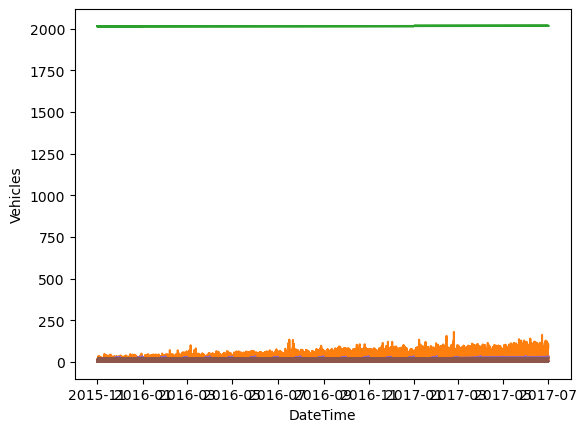

In [10]:
plt.xlabel('DateTime')
plt.ylabel('Vehicles')
plt.plot(new_df)

In [11]:
rolmean = new_df.rolling(window=12).mean()
rolstd = new_df.rolling(window=12).std()

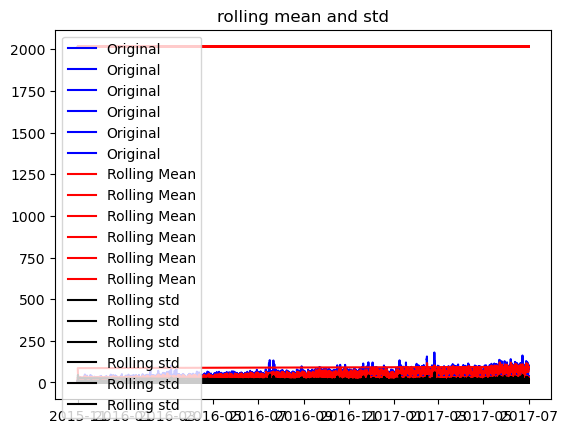

In [12]:
orig = plt.plot(new_df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling std')
plt.legend(loc='best')
plt.title('rolling mean and std')
plt.show(block=False)

### Performing Dickey-Fuller test:

In [13]:
from statsmodels.tsa.stattools import adfuller

In [14]:
print("Result of Dickey Fuller test: ")
dftest = adfuller(new_df['Vehicles'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print(dfoutput)

Result of Dickey Fuller test: 
Test Statistic               -7.518278e+00
p-value                       3.851060e-11
#Lags Used                    5.700000e+01
Number of Observation used    4.806200e+04
Critical Value (1%)          -3.430486e+00
Critical Value (5%)          -2.861600e+00
Critical Value (10%)         -2.566802e+00
dtype: float64


### Moving Average

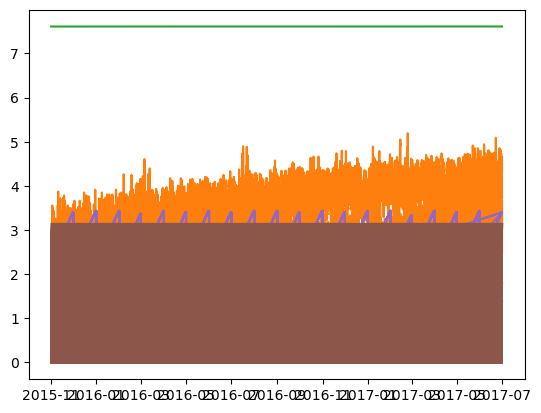

In [15]:
indexed_dataset_logscale = np.log(new_df)
plt.plot(indexed_dataset_logscale)

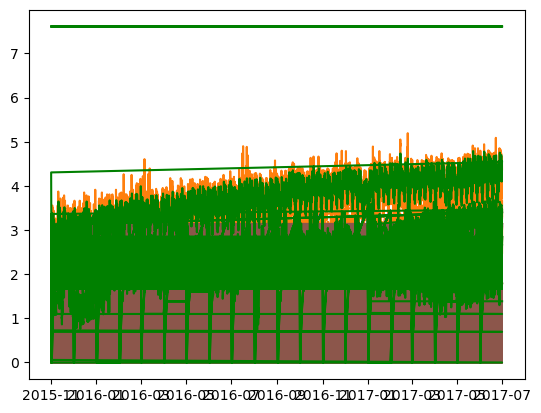

In [16]:
movingavg = indexed_dataset_logscale.rolling(window=12).mean()
movingstd = indexed_dataset_logscale.rolling(window=12).std()
plt.plot(indexed_dataset_logscale)
plt.plot(movingavg, color='green')

In [17]:
logScaleMinusMovingAvg = indexed_dataset_logscale - movingavg
logScaleMinusMovingAvg.head(4)

logScaleMinusMovingAvg.dropna(inplace=True)
logScaleMinusMovingAvg.head(4)

,Junction,Vehicles,year,month,day,hour
DateTime,,,,,,
2015-11-01 12:00:00,0.0,0.416276,-8.881784e-16,0.0,0.0,0.819305
2015-11-01 13:00:00,0.0,0.339813,-8.881784e-16,0.0,0.0,0.685602
2015-11-01 14:00:00,0.0,0.365184,-8.881784e-16,0.0,0.0,0.597551
2015-11-01 15:00:00,0.0,0.032586,-8.881784e-16,0.0,0.0,0.532424


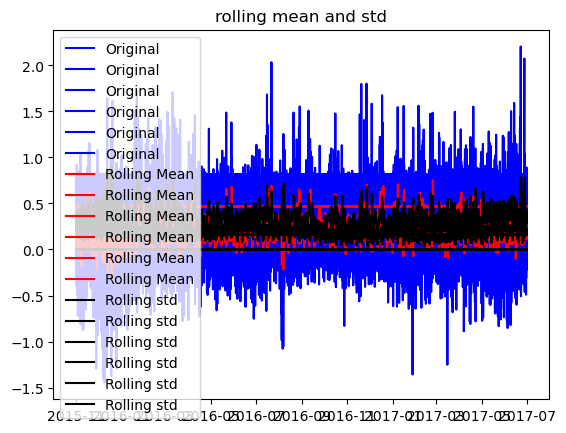

Result of Dickey Fuller test: 
Test Statistic               -1.520424e+01
p-value                       5.772459e-28
#Lags Used                    4.800000e+01
Number of Observation used    2.401100e+04
Critical Value (1%)          -3.430622e+00
Critical Value (5%)          -2.861660e+00
Critical Value (10%)         -2.566834e+00
dtype: float64


In [53]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling std')
    plt.legend(loc='best')
    plt.title('rolling mean and std')
    plt.show(block=False)
    
    print("Result of Dickey Fuller test: ")
    dftest = adfuller(timeseries['Vehicles'], autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    
test_stationarity(logScaleMinusMovingAvg)

### Weighted avg of timeseries

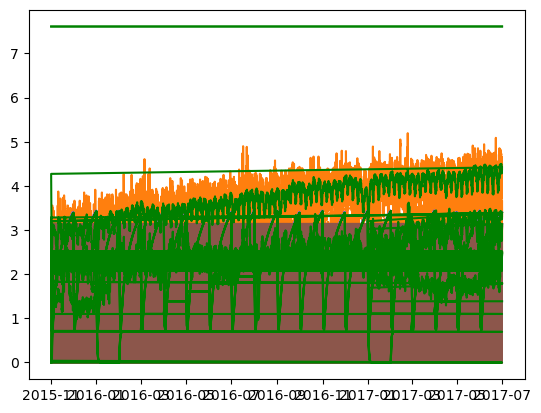

In [19]:
expoDecayWeightedAvg = indexed_dataset_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexed_dataset_logscale)
plt.plot(expoDecayWeightedAvg, color='green')

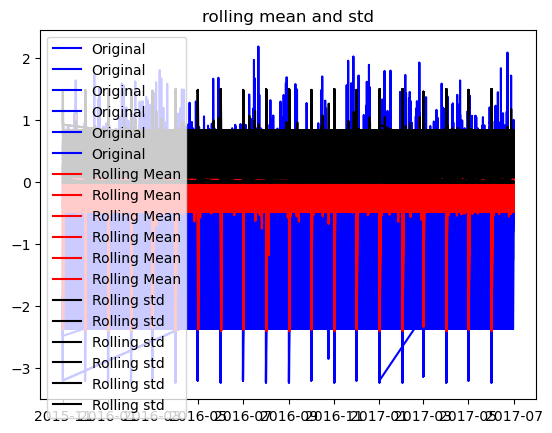

Result of Dickey Fuller test: 
Test Statistic                  -35.819815
p-value                           0.000000
#Lags Used                       56.000000
Number of Observation used    48063.000000
Critical Value (1%)              -3.430486
Critical Value (5%)              -2.861600
Critical Value (10%)             -2.566802
dtype: float64


In [20]:
logScaleMinusDecayAvg = indexed_dataset_logscale - expoDecayWeightedAvg
test_stationarity(logScaleMinusDecayAvg)

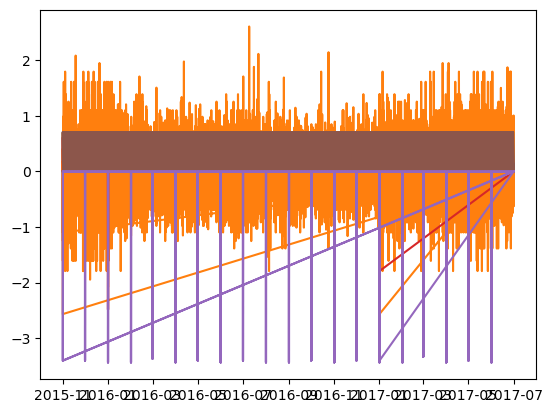

In [51]:
dataLogDiffShift = indexed_dataset_logscale- indexed_dataset_logscale.shift()
plt.plot(dataLogDiffShift)

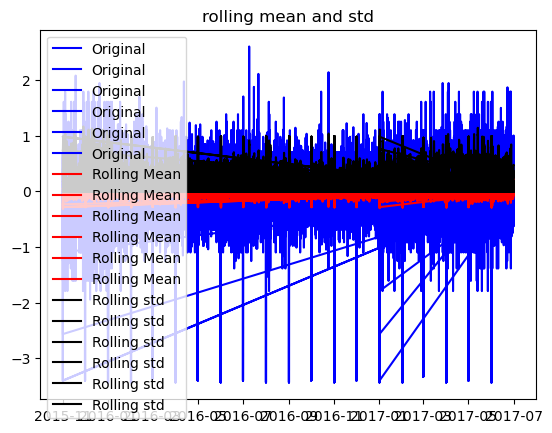

Result of Dickey Fuller test: 
Test Statistic                  -34.145554
p-value                           0.000000
#Lags Used                       57.000000
Number of Observation used    48061.000000
Critical Value (1%)              -3.430486
Critical Value (5%)              -2.861600
Critical Value (10%)             -2.566802
dtype: float64


In [24]:
dataLogDiffShift.dropna(inplace=True)
test_stationarity(dataLogDiffShift)

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Vehicles'], model='additive', period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

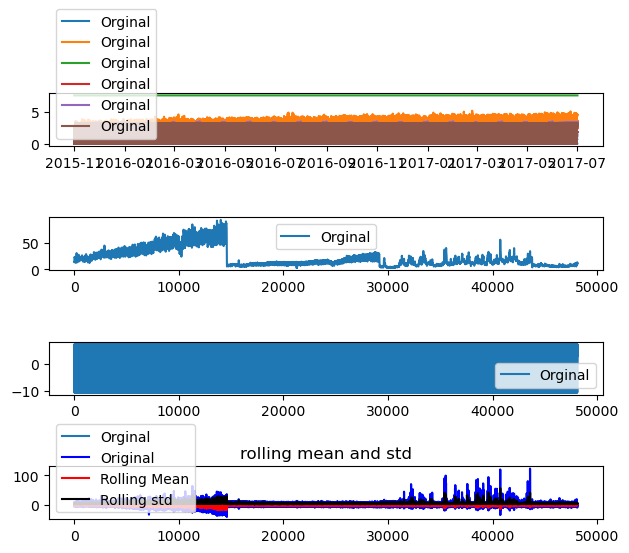

Result of Dickey Fuller test: 
Test Statistic                  -42.070261
p-value                           0.000000
#Lags Used                       57.000000
Number of Observation used    48038.000000
Critical Value (1%)              -3.430486
Critical Value (5%)              -2.861600
Critical Value (10%)             -2.566802
dtype: float64


In [48]:
plt.subplot(411)
plt.plot(indexed_dataset_logscale, label='Orginal')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Orginal')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Orginal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Orginal')
plt.legend(loc='best')
plt.tight_layout()

decomposed_data = residual
decomposed_data.dropna(inplace=True)
test_stationarity(decomposed_data)

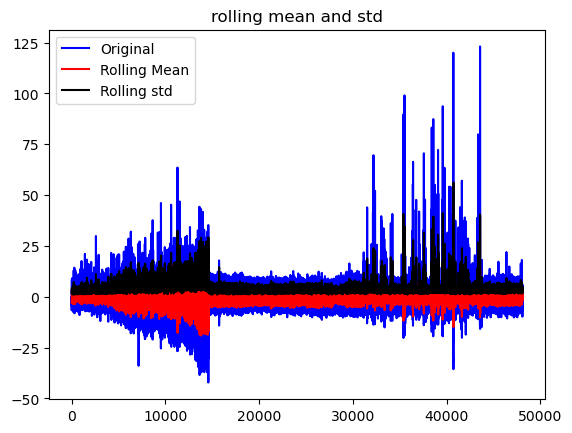

Result of Dickey Fuller test: 
Test Statistic                  -42.070261
p-value                           0.000000
#Lags Used                       57.000000
Number of Observation used    48038.000000
Critical Value (1%)              -3.430486
Critical Value (5%)              -2.861600
Critical Value (10%)             -2.566802
dtype: float64


In [49]:
decomposed_data = residual
decomposed_data.dropna(inplace=True)
test_stationarity(decomposed_data)

In [60]:
from statsmodels.tsa.stattools import acf, pacf
# col_name = dataLogDiffShift['Vehicles']
lag_acf = acf(dataLogDiffShift, nlags=20)
lag_pacf = pacf(dataLogDiffShift, nlags=20, method='ols')

ValueError: x is required to have ndim 1 but has ndim 2

### Arima Model

C:\Users\ASUS\miniconda3\envs\stan_env_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\miniconda3\envs\stan_env_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\miniconda3\envs\stan_env_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ASUS\miniconda3\envs\stan_env_test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

Text(0.5, 1.0, 'RSS: nan')

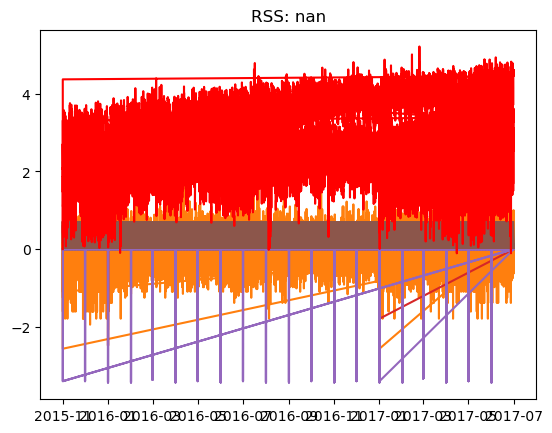

In [76]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(indexed_dataset_logscale['Vehicles'], order=(2,1,2))
result_ar = model.fit()
plt.plot(dataLogDiffShift)
plt.plot(result_ar.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum(result_ar.fittedvalues-dataLogDiffShift['Vehicles'])**2)